In [1]:
# khai báo thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# các lớp để xây dựng mô hình
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

# kiểm tra độ chính xác của các mô hình
from sklearn.metrics import r2_score # đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # đo phần trăm sai số tuyệt đối trung bình

# Load và xử lý dữ liệu

In [2]:
df = pd.read_csv("4.2.3 (TARGET) (live & his) FPT_detail_transactions_processed.csv")
df.head()

,StockID,Date,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
0,FPT,12/03/2025,"6,365,000","870,067","199,918,302","135,900","-1,600",-1.16,"6,185,000","844,877"
1,FPT,11/03/2025,"6,164,400","849,430","202,272,013","137,500","-1,800",-1.29,"5,784,400","797,080"
2,FPT,10/03/2025,"5,681,900","796,168","204,919,937","139,300","-2,100",-1.49,"5,323,000","745,248"
3,FPT,07/03/2025,"3,436,000","486,821","208,009,182","141,400",-200,-0.14,"2,954,500","418,579"
4,FPT,06/03/2025,"6,511,400","921,080","208,303,396","141,600","2,500",1.80,"6,417,100","907,741"


In [3]:
df.Date = pd.to_datetime(df.Date, format = "%d/%m/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   StockID         240 non-null    object        
 1   Date            240 non-null    datetime64[ns]
 2   Total Volume    240 non-null    object        
 3   Total Value     240 non-null    object        
 4   Market Cap      240 non-null    object        
 5   Closing Price   240 non-null    object        
 6   Price Change    240 non-null    object        
 7   Price Change %  240 non-null    float64       
 8   Matched Volume  240 non-null    object        
 9   Matched Value   240 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 18.9+ KB


In [4]:
df['Price Change %'] = df['Price Change %']/100

In [5]:
def convert_columns_to_int(df, cols):
    df[cols] = (
        df[cols]
        .astype(str)
        .replace(',', '', regex=True)
        .astype(float)
        .round()
        .astype(int)
    )
    return df

In [6]:
cols_to_convert = ['Total Volume', 'Total Value', 'Market Cap','Closing Price', 'Price Change', 'Matched Volume','Matched Value']
df = convert_columns_to_int(df, cols_to_convert)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   StockID         240 non-null    object        
 1   Date            240 non-null    datetime64[ns]
 2   Total Volume    240 non-null    int32         
 3   Total Value     240 non-null    int32         
 4   Market Cap      240 non-null    int32         
 5   Closing Price   240 non-null    int32         
 6   Price Change    240 non-null    int32         
 7   Price Change %  240 non-null    float64       
 8   Matched Volume  240 non-null    int32         
 9   Matched Value   240 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(7), object(1)
memory usage: 12.3+ KB


In [7]:
df = df.sort_values(by='Date', ascending=True)
df

,StockID,Date,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
239,FPT,2024-03-26,3110290,365684,146046421,115000,1000,0.0088,1693300,193338
238,FPT,2024-03-27,1467800,168909,146300414,115200,200,0.0017,1320200,151372
237,FPT,2024-03-28,2854400,333719,148713355,117100,1900,0.0165,2803200,327411
236,FPT,2024-03-29,2594300,310422,147951374,116500,-600,-0.0051,1343500,156545
235,FPT,2024-04-01,3243600,387065,148332365,116800,300,0.0026,1974600,229434
...,...,...,...,...,...,...,...,...,...,...
4,FPT,2025-03-06,6511400,921080,208303396,141600,2500,0.0180,6417100,907741
3,FPT,2025-03-07,3436000,486821,208009182,141400,-200,-0.0014,2954500,418579
2,FPT,2025-03-10,5681900,796168,204919937,139300,-2100,-0.0149,5323000,745248
1,FPT,2025-03-11,6164400,849430,202272013,137500,-1800,-0.0129,5784400,797080


In [8]:
df = df.set_index('Date')
df

,StockID,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
Date,,,,,,,,,
2024-03-26,FPT,3110290,365684,146046421,115000,1000,0.0088,1693300,193338
2024-03-27,FPT,1467800,168909,146300414,115200,200,0.0017,1320200,151372
2024-03-28,FPT,2854400,333719,148713355,117100,1900,0.0165,2803200,327411
2024-03-29,FPT,2594300,310422,147951374,116500,-600,-0.0051,1343500,156545
2024-04-01,FPT,3243600,387065,148332365,116800,300,0.0026,1974600,229434
...,...,...,...,...,...,...,...,...,...
2025-03-06,FPT,6511400,921080,208303396,141600,2500,0.0180,6417100,907741
2025-03-07,FPT,3436000,486821,208009182,141400,-200,-0.0014,2954500,418579
2025-03-10,FPT,5681900,796168,204919937,139300,-2100,-0.0149,5323000,745248


In [9]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(['object'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_22260\1243517510.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


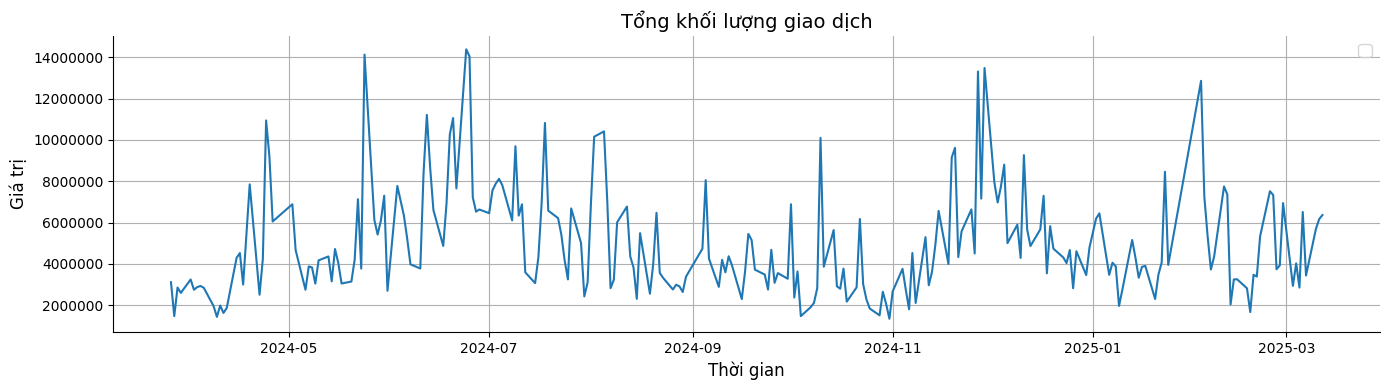

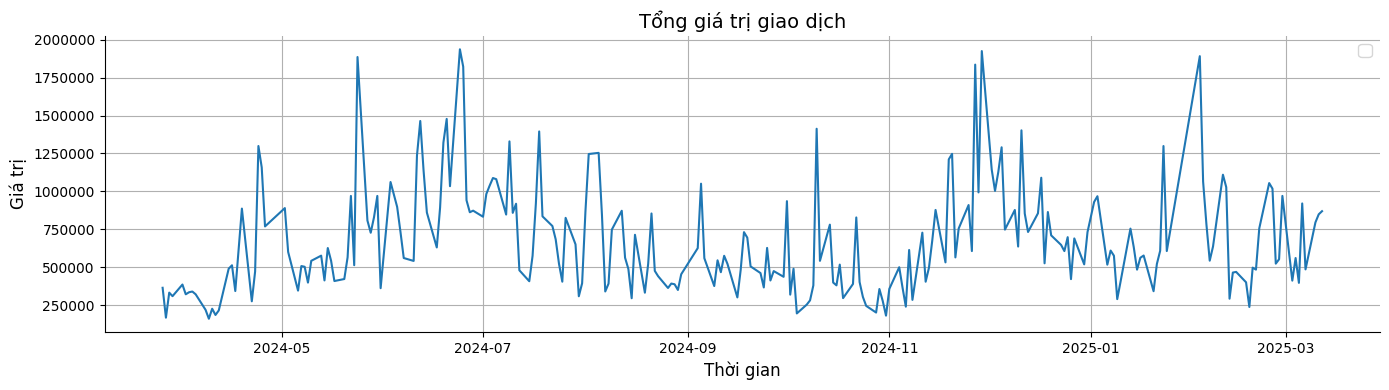

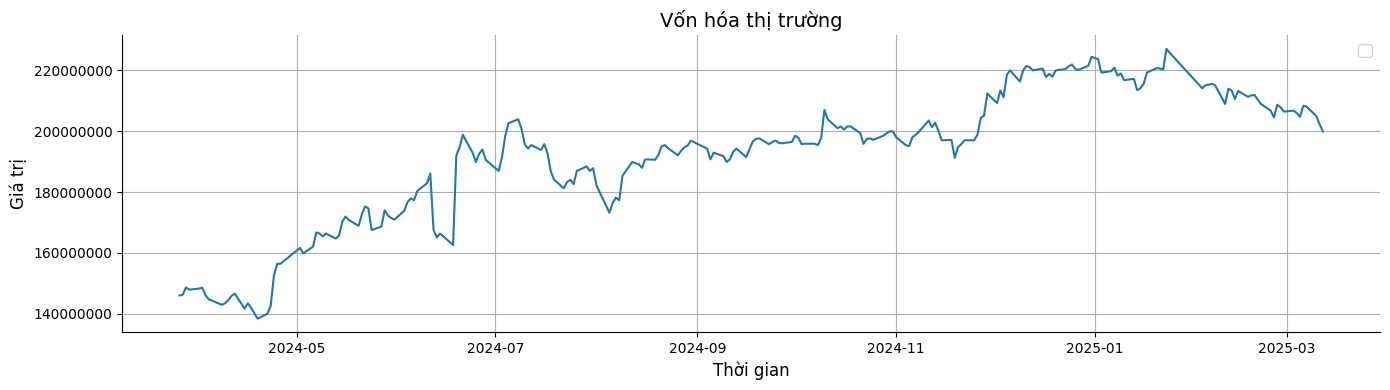

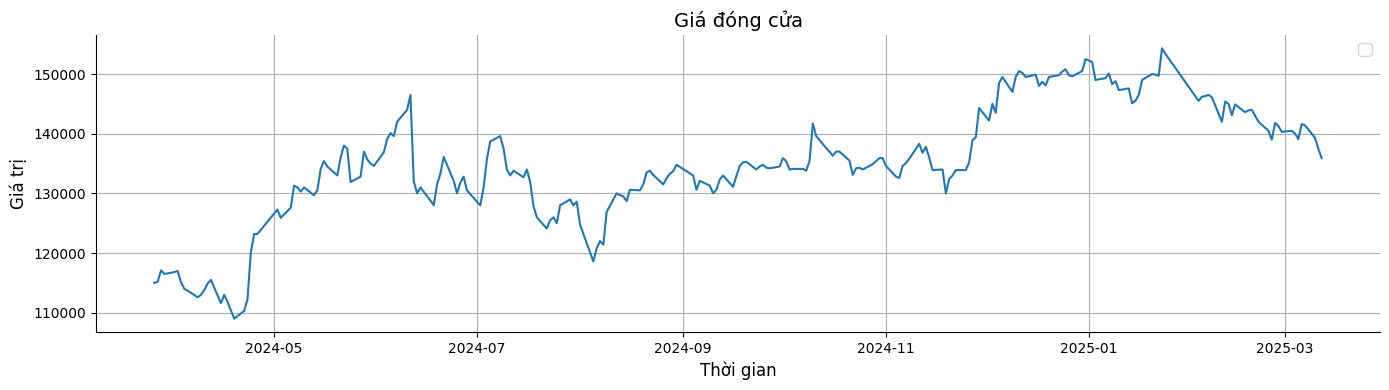

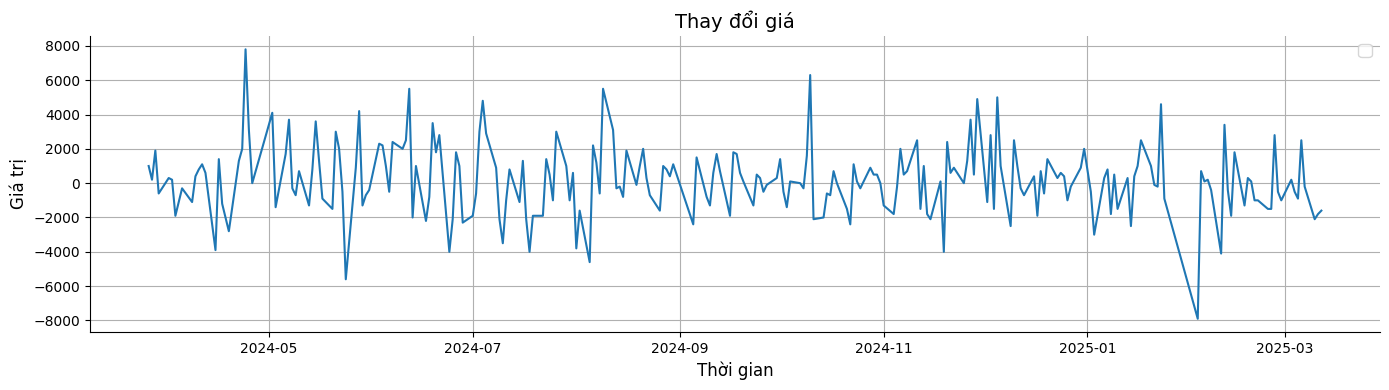

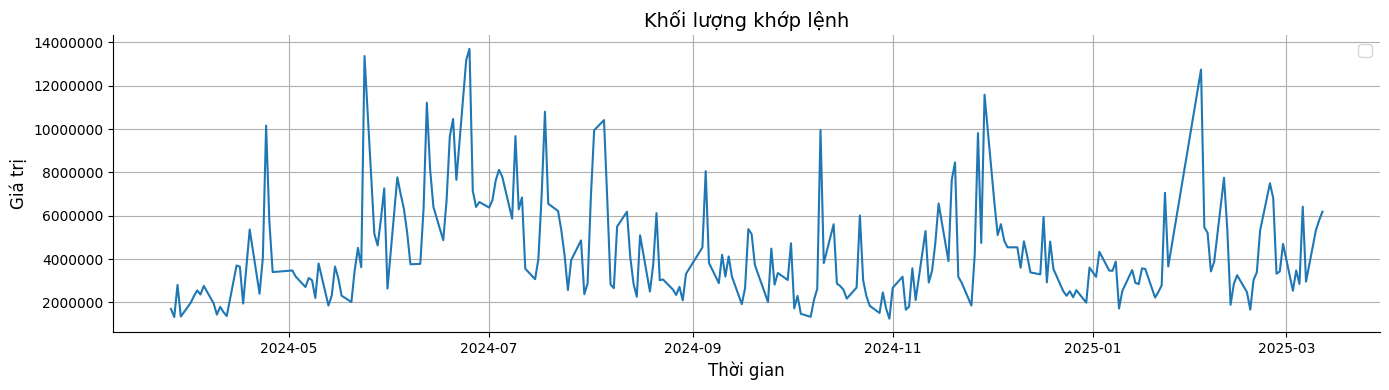

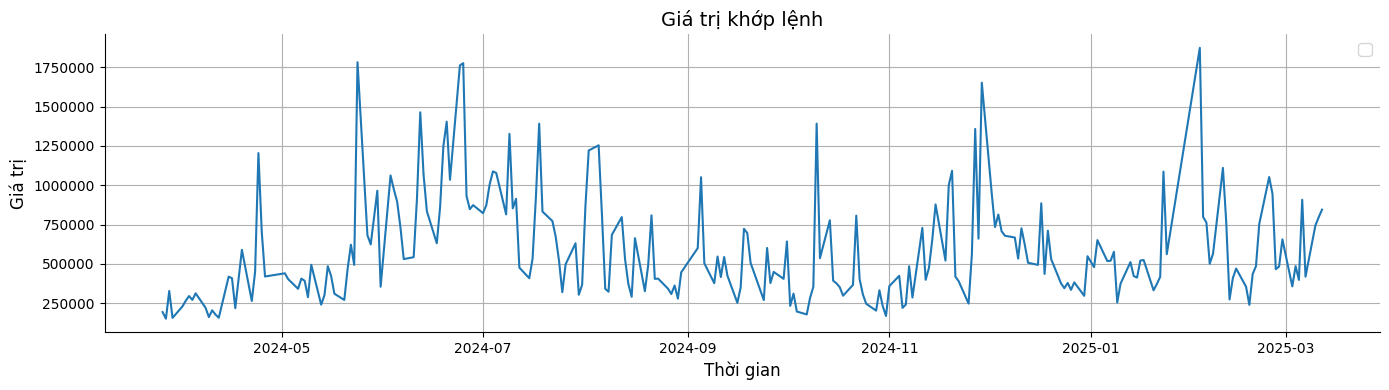

In [10]:
fields_vn = {
    'Total Volume': 'Tổng khối lượng giao dịch',
    'Total Value': 'Tổng giá trị giao dịch',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

for field, label in fields_vn.items():
    plt.figure(figsize=(14, 4))
    plt.plot(df[field])
    plt.title(label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    ax = plt.gca()

    # Ẩn viền trên và bên phải
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Hiển thị số nguyên, không dạng e^
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style='plain', axis='y')

    plt.xlabel("Thời gian", fontsize=12)
    plt.ylabel("Giá trị", fontsize=12)

    plt.tight_layout()
    plt.show()

In [11]:
ma_day = [10,20,50]

for ma in ma_day:
  df[f'MA_{ma}'] = df['Closing Price'].rolling(ma).mean()

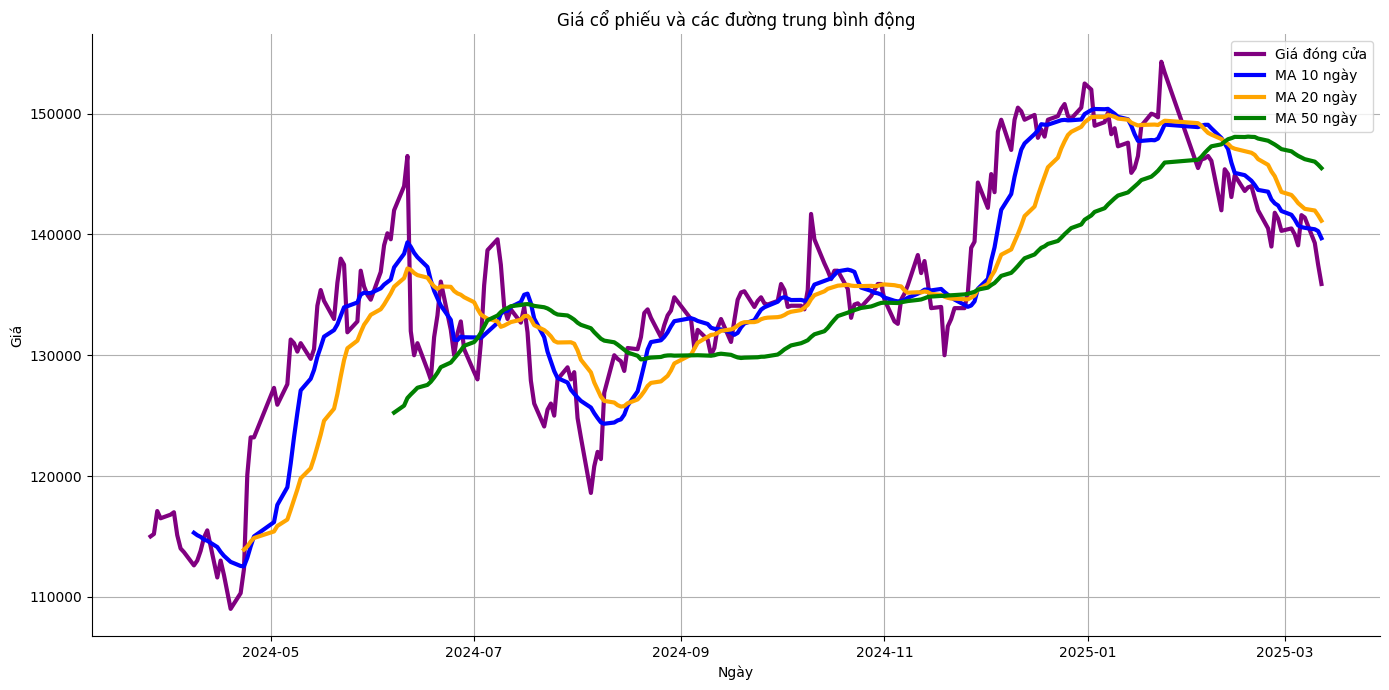

In [12]:
plt.figure(figsize=(14, 7))

# giá đóng cửa
plt.plot(df['Closing Price'], label='Giá đóng cửa', color='purple', linewidth=3)
# các đường MA
plt.plot(df['MA_10'], label='MA 10 ngày', color='blue', linewidth=3)
plt.plot(df['MA_20'], label='MA 20 ngày', color='orange', linewidth=3)
plt.plot(df['MA_50'], label='MA 50 ngày', color='green', linewidth=3)
plt.title('Giá cổ phiếu và các đường trung bình động')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Ẩn viền trên và phải
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

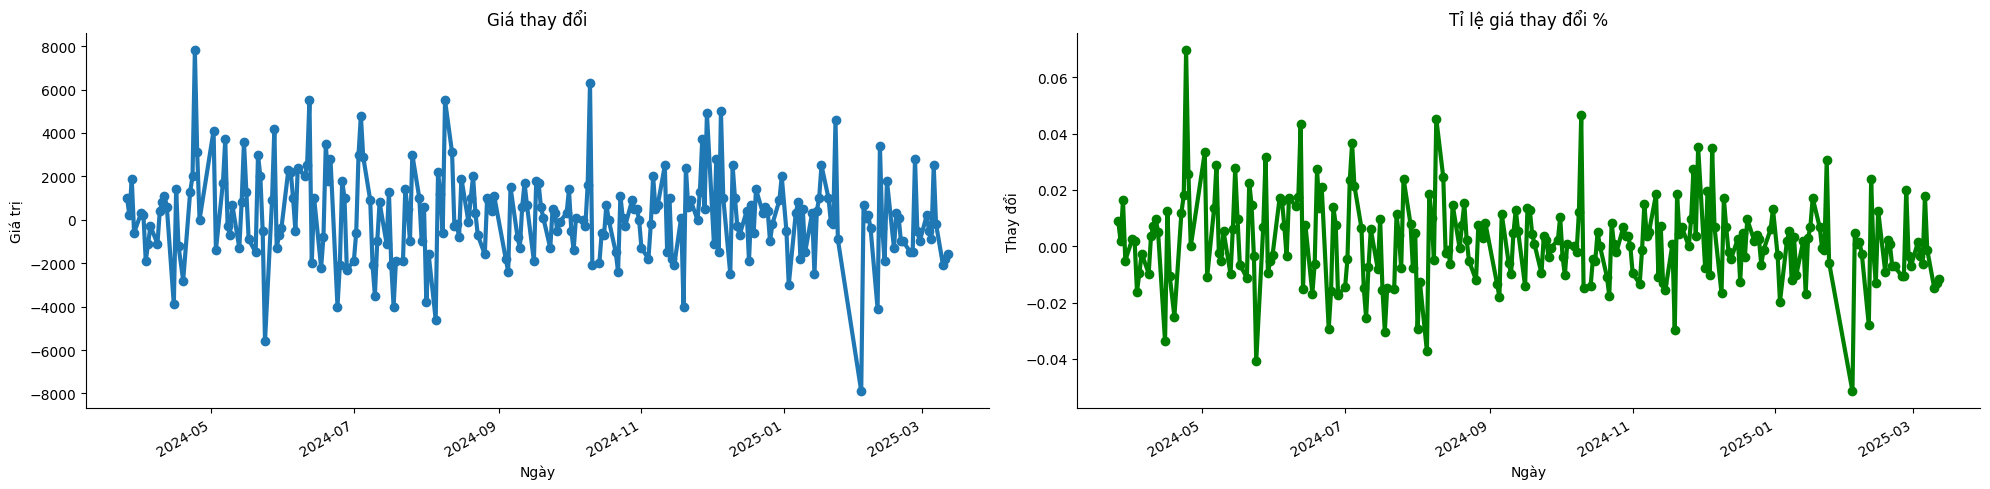

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# Biểu đồ 1: Price Change
df['Price Change'].plot(ax=axes[0], marker='o', linewidth=3)
axes[0].set_title('Giá thay đổi')
axes[0].set_xlabel('Ngày')
axes[0].set_ylabel('Giá trị')

# Ẩn viền trên và phải cho biểu đồ 1
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Biểu đồ 2: Price Change %
df['Price Change %'].plot(ax=axes[1], marker='o', color='green', linewidth=3)
axes[1].set_title('Tỉ lệ giá thay đổi %')
axes[1].set_xlabel('Ngày')
axes[1].set_ylabel('Thay đổi')

# Ẩn viền trên và phải cho biểu đồ 2
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

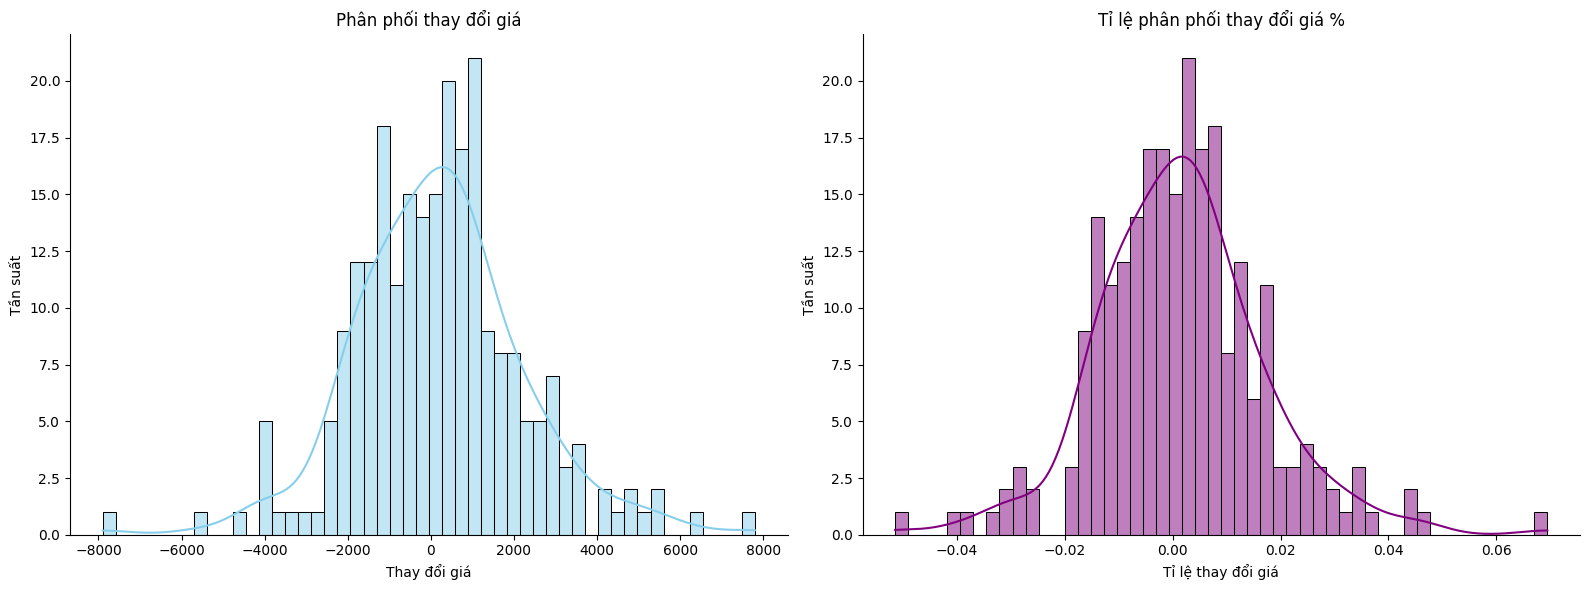

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Price Change
sns.histplot(data=df, x='Price Change', bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Phân phối thay đổi giá')
axes[0].set_xlabel('Thay đổi giá')
axes[0].set_ylabel('Tần suất')


# Ẩn viền trên và phải cho biểu đồ 2
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Subplot 2: Price Change %
sns.histplot(data=df, x='Price Change %', bins=50, kde=True, color='purple', ax=axes[1])
axes[1].set_title('Tỉ lệ phân phối thay đổi giá %')
axes[1].set_xlabel('Tỉ lệ thay đổi giá')
axes[1].set_ylabel('Tần suất')


# Ẩn viền trên và phải cho biểu đồ 2
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

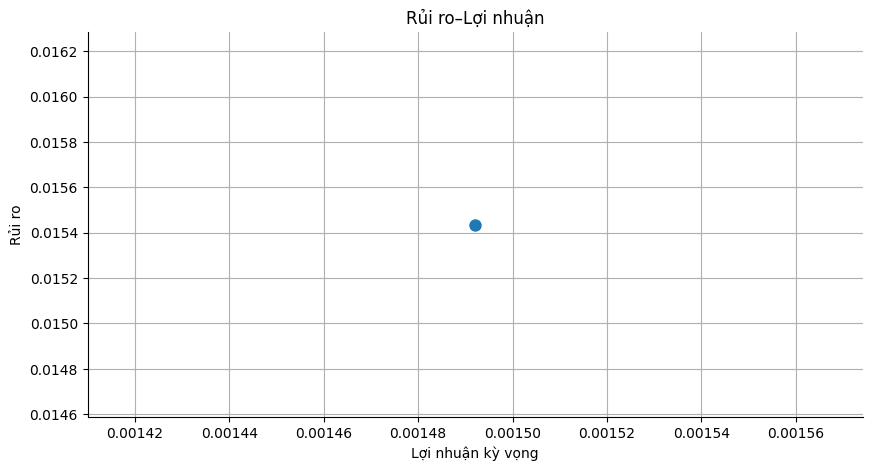

In [15]:
area = np.pi*20

plt.figure(figsize=(10,5))
plt.scatter(df['Price Change %'].mean(), df['Price Change %'].std(), s=area)
plt.title('Rủi ro–Lợi nhuận')
plt.xlabel('Lợi nhuận kỳ vọng')
plt.ylabel('Rủi ro')

# Ẩn viền trên và phải
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.show()

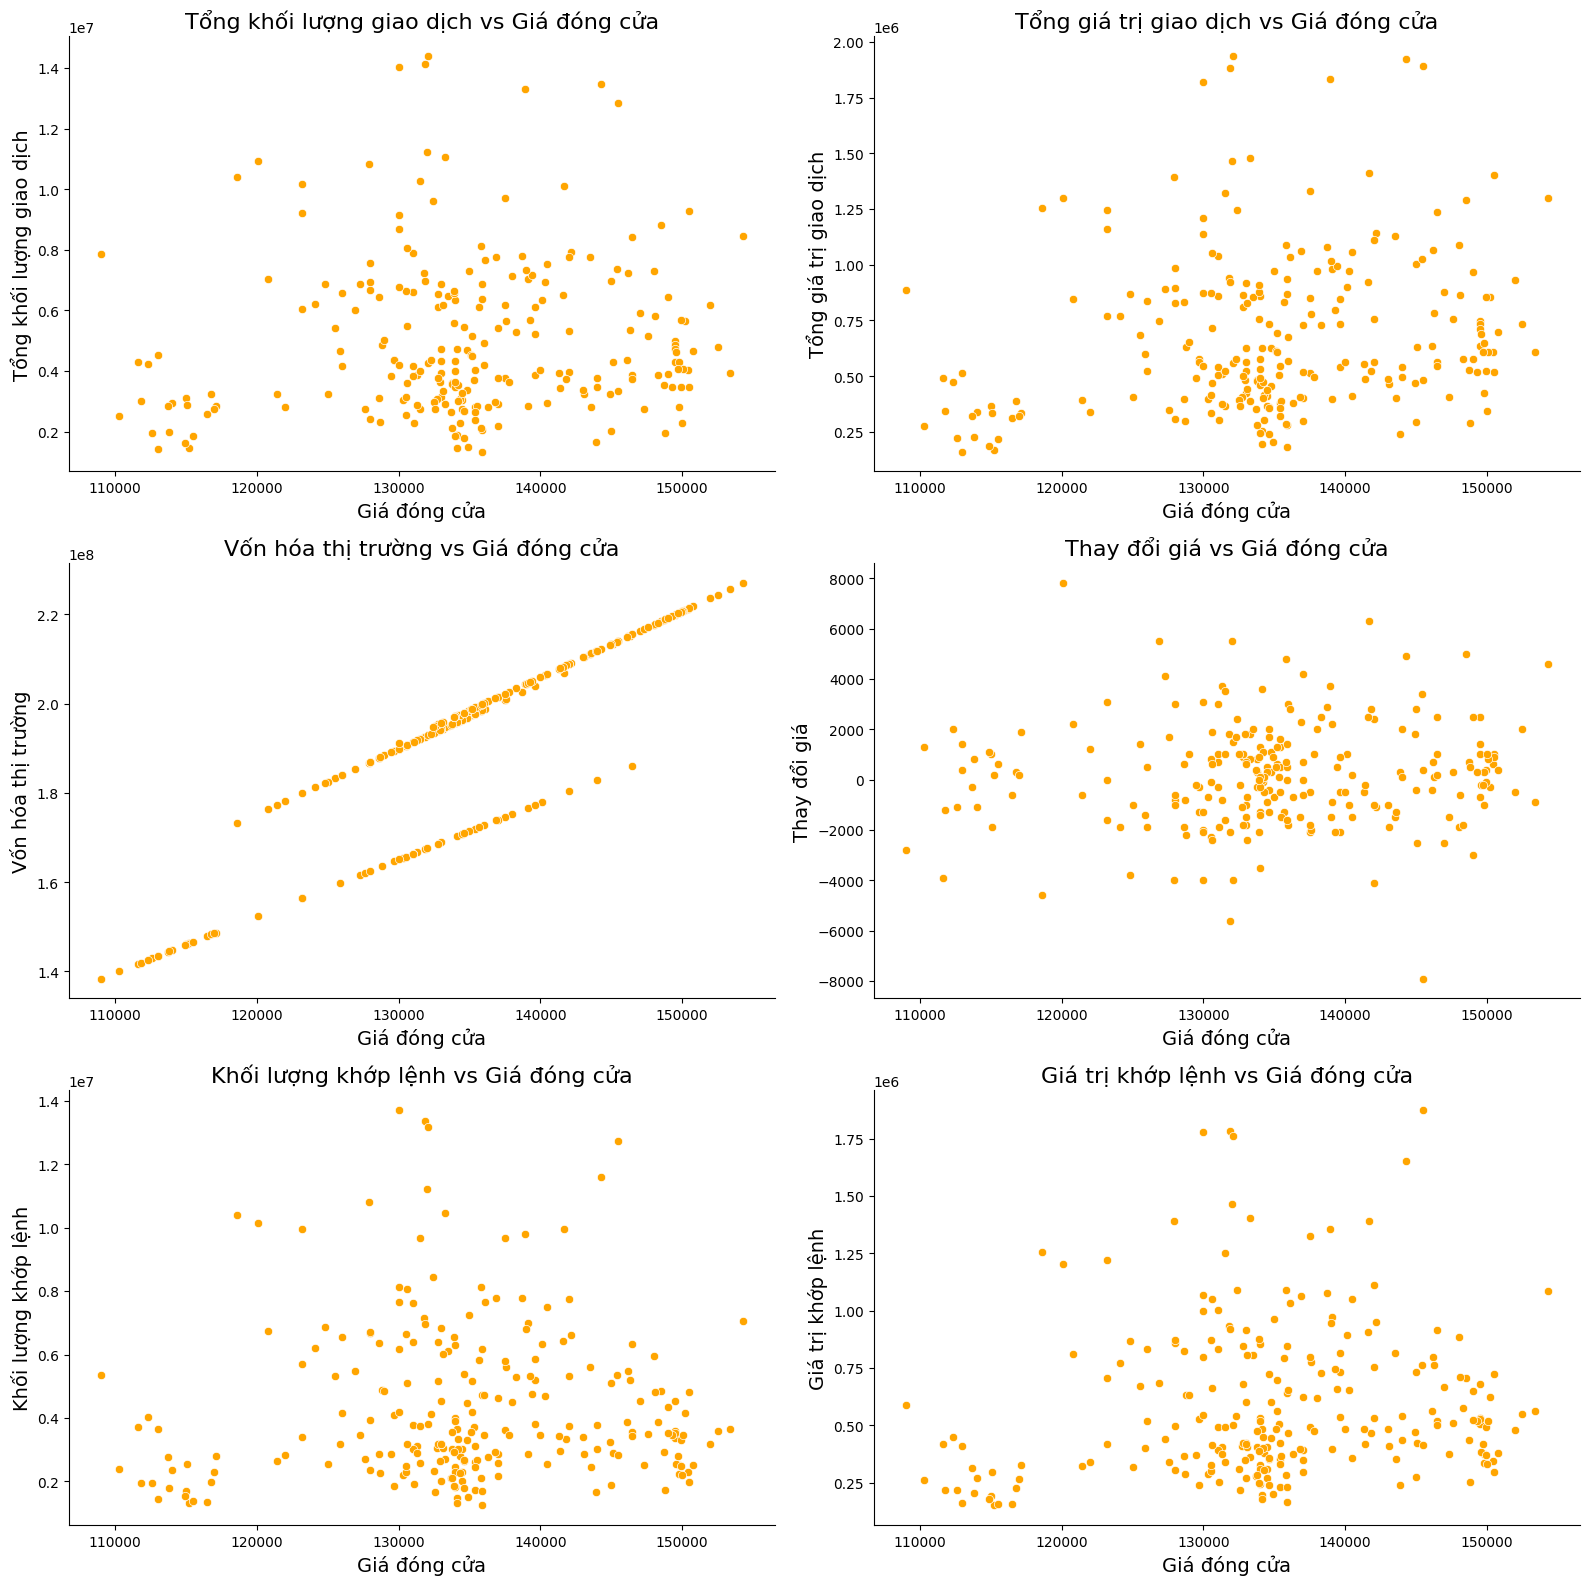

In [16]:
features = [
    'Total Volume',
    'Total Value',
    'Market Cap',
    'Price Change',
    'Matched Volume',
    'Matched Value'
]

# Từ điển chuyển đổi sang tiếng Việt
fields_vn = {
    'Total Volume': 'Tổng khối lượng giao dịch',
    'Total Value': 'Tổng giá trị giao dịch',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

sns.set_palette('PiYG')
plt.figure(figsize=(16, 26))

for idx, column in enumerate(features):
    plt.subplot(5, 2, idx + 1)
    sns.scatterplot(
        x=df['Closing Price'],
        y=df[column],
        data=df,
        color='orange'
    )
    plt.title(f'{fields_vn.get(column, column)} vs Giá đóng cửa', fontsize=16)
    plt.xlabel('Giá đóng cửa', fontsize=14)
    plt.ylabel(fields_vn.get(column, column), fontsize=14)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

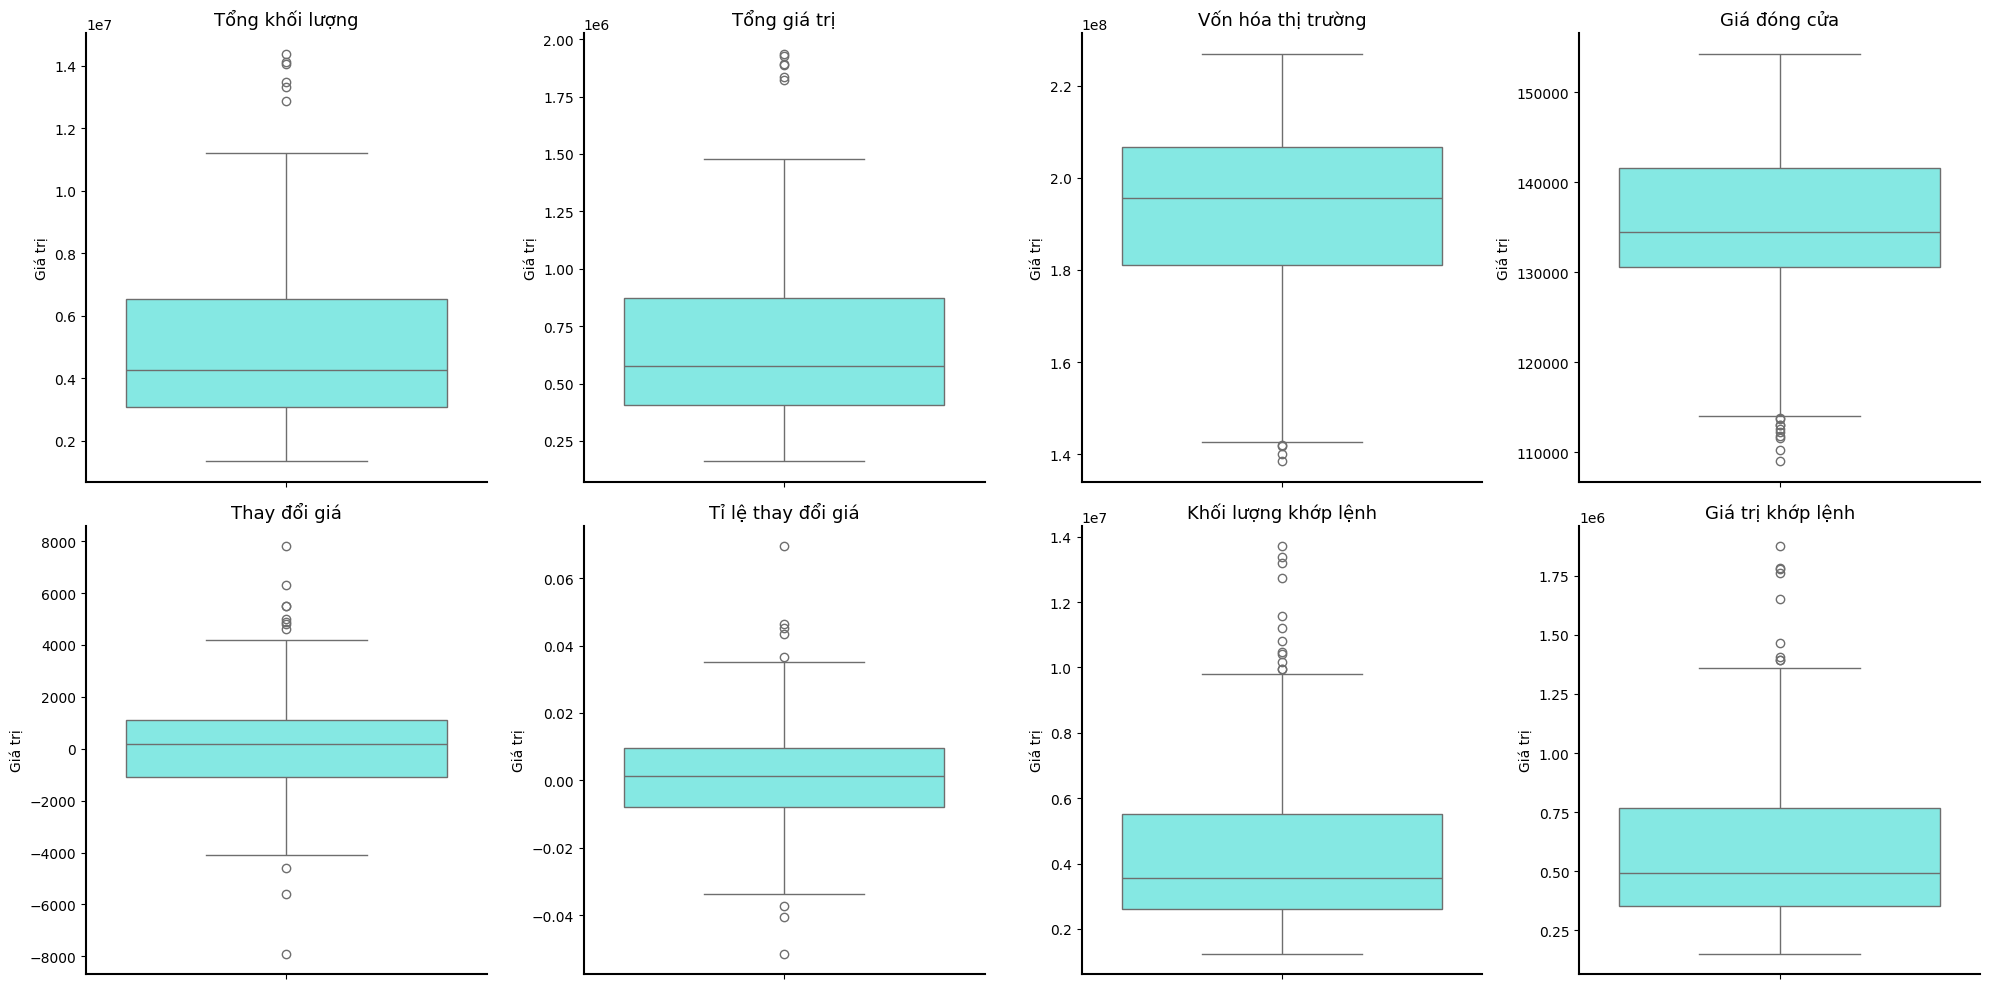

In [17]:
# Danh sách cột
features = ['Total Volume', 'Total Value', 'Market Cap', 'Closing Price',
            'Price Change', 'Price Change %', 'Matched Volume', 'Matched Value']

# Ánh xạ tên cột sang tiếng Việt
fields_vn = {
    'Total Volume': 'Tổng khối lượng',
    'Total Value': 'Tổng giá trị',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Price Change %': 'Tỉ lệ thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

# Tạo lưới 2 hàng, 4 cột
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(y=df[col], ax=axes[i], color='#75f8f2')
    axes[i].set_title(f'{fields_vn.get(col, col)}', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Giá trị')

    # Ẩn viền trên và phải
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    for spine in ['left', 'bottom']:
        axes[i].spines[spine].set_linewidth(1.5)
        axes[i].spines[spine].set_edgecolor('black')

plt.tight_layout()
plt.show()

# Dự báo giá chứng khoán

In [18]:
data = df[['Closing Price']]
dataset = data.values

Xét các yếu tố liên quan

<Figure size 1500x500 with 0 Axes>

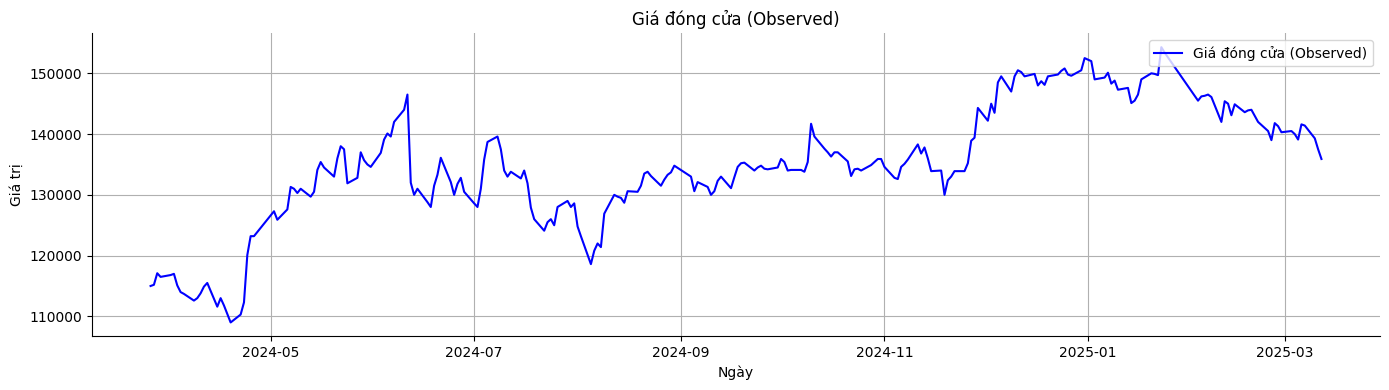

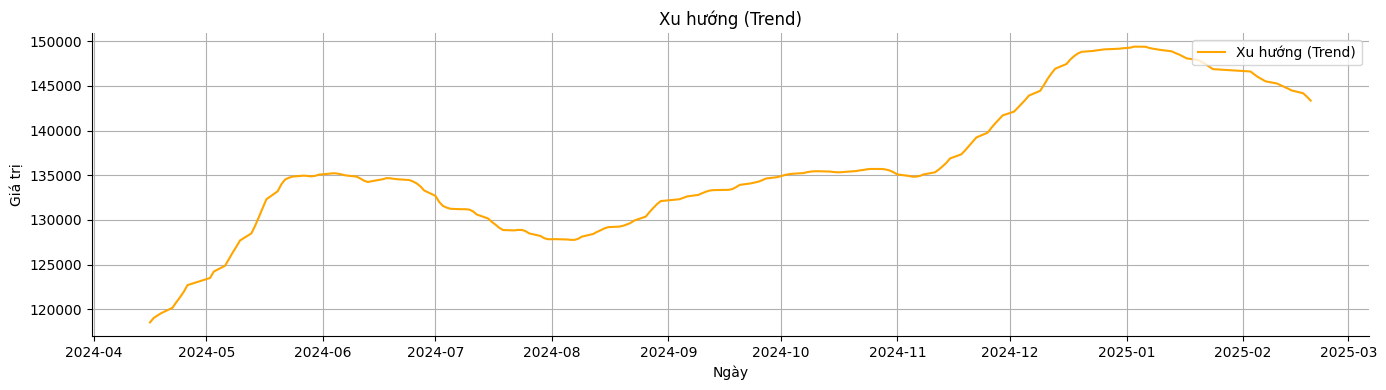

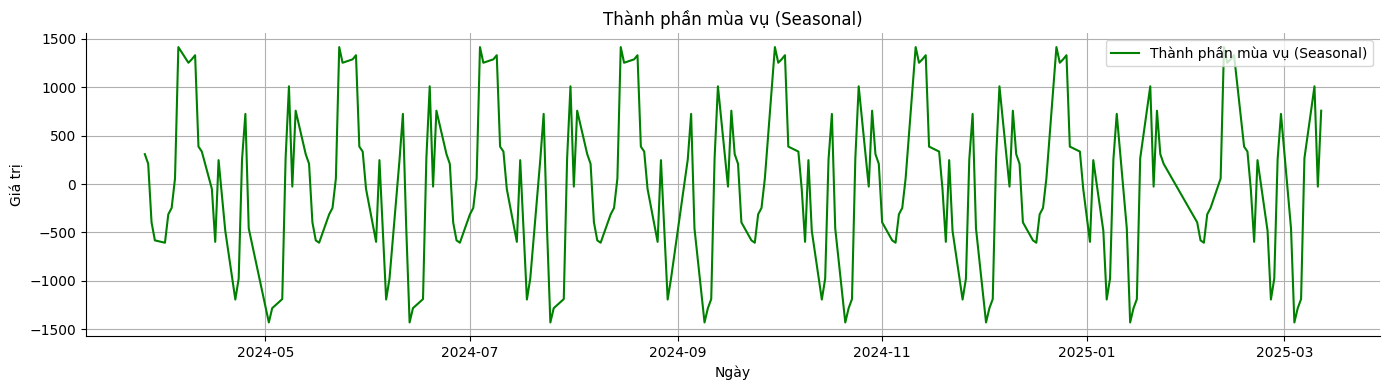

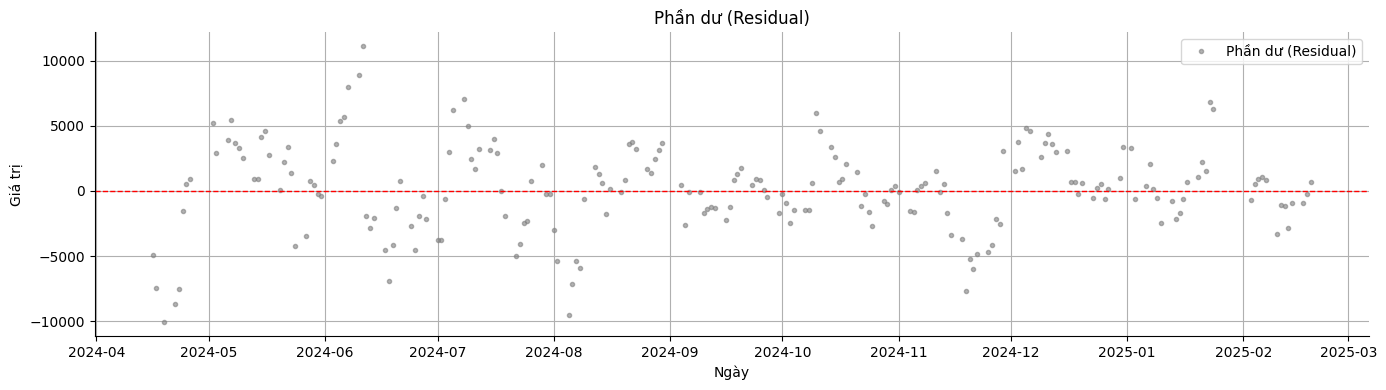

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15,5))
# Phân tích chuỗi thời gian
decomposeResult = seasonal_decompose(data['Closing Price'], model='additive', period=30)

# Danh sách thành phần và thiết lập hiển thị
components = {
    'Observed': ('Giá đóng cửa (Observed)', decomposeResult.observed, 'blue'),
    'Trend': ('Xu hướng (Trend)', decomposeResult.trend, 'orange'),
    'Seasonal': ('Thành phần mùa vụ (Seasonal)', decomposeResult.seasonal, 'green'),
    'Residual': ('Phần dư (Residual)', decomposeResult.resid, 'gray')
}

for key, (title, series, color) in components.items():
    plt.figure(figsize=(14, 4))
    if key == 'Residual':
        plt.plot(series, label=title, linestyle='', marker='o', markersize=3, alpha=0.6, color=color)
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
    else:
        plt.plot(series, label=title, color=color)

    plt.title(title)
    plt.xlabel("Ngày")
    plt.ylabel("Giá trị")
    plt.grid(True)
    plt.legend()

    plt.legend(loc='upper right')

    # Ẩn khung viền trên và phải
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [20]:
training_data_len = int(np.ceil(len(dataset) * .80))

In [21]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(dataset)

In [22]:
train_data = scaler_data[0:training_data_len, :]
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(train_data[i-50:i, 0])
    y_train.append(train_data[i, 0])

In [23]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [24]:
# Xây dựng mô hình
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
save_model = "FPT.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện
model.fit(x_train, y_train, batch_size=50, epochs=100, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.23950, saving model to FPT.keras
3/3 - 17s - 6s/step - loss: 0.2395
Epoch 2/100

Epoch 2: loss improved from 0.23950 to 0.03508, saving model to FPT.keras
3/3 - 1s - 282ms/step - loss: 0.0351
Epoch 3/100

Epoch 3: loss did not improve from 0.03508
3/3 - 1s - 168ms/step - loss: 0.0443
Epoch 4/100

Epoch 4: loss improved from 0.03508 to 0.02157, saving model to FPT.keras
3/3 - 1s - 283ms/step - loss: 0.0216
Epoch 5/100

Epoch 5: loss did not improve from 0.02157
3/3 - 1s - 223ms/step - loss: 0.0324
Epoch 6/100

Epoch 6: loss did not improve from 0.02157
3/3 - 1s - 194ms/step - loss: 0.0249
Epoch 7/100

Epoch 7: loss improved from 0.02157 to 0.01775, saving model to FPT.keras
3/3 - 1s - 280ms/step - loss: 0.0177
Epoch 8/100

Epoch 8: loss did not improve from 0.01775
3/3 - 0s - 160ms/step - loss: 0.0194
Epoch 9/100

Epoch 9: loss improved from 0.01775 to 0.01635, saving model to FPT.keras
3/3 - 1s - 207ms/step - loss: 0.0163
Epoch 10/100



In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,101 (1.33 MB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,068 (906.52 KB)

In [27]:
# Load model tốt nhất
final_model = load_model('FPT.keras')

In [28]:
# Dự đoán và đánh giá trên tập huấn luyện
y_train = scaler.inverse_transform(y_train)
y_train_predict = final_model.predict(x_train)
y_train_predict = scaler.inverse_transform(y_train_predict)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


In [29]:
# Chuẩn bị dữ liệu test
test = data[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = scaler.transform(test)

x_test = []
for i in range(50, sc_test.shape[0]):
    x_test.append(sc_test[i-50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
# Dự đoán trên tập test
y_test = data[training_data_len:]
y_test_predict = final_model.predict(x_test)
y_test_predict = scaler.inverse_transform(y_test_predict)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [31]:
# Đánh giá mô hình
r2_train = r2_score(y_train, y_train_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mape_train = mean_absolute_percentage_error(y_train, y_train_predict)

r2_test = r2_score(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
mape_test = mean_absolute_percentage_error(y_test, y_test_predict)

print(f"Train R2: {r2_train:.4f}, MAE: {mae_train:.4f}, MAPE: {mape_train:.4f}")
print(f"Test R2: {r2_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.4f}")

Train R2: 0.7285, MAE: 2672.8049, MAPE: 0.0199
Test R2: 0.6931, MAE: 1801.3096, MAPE: 0.0123


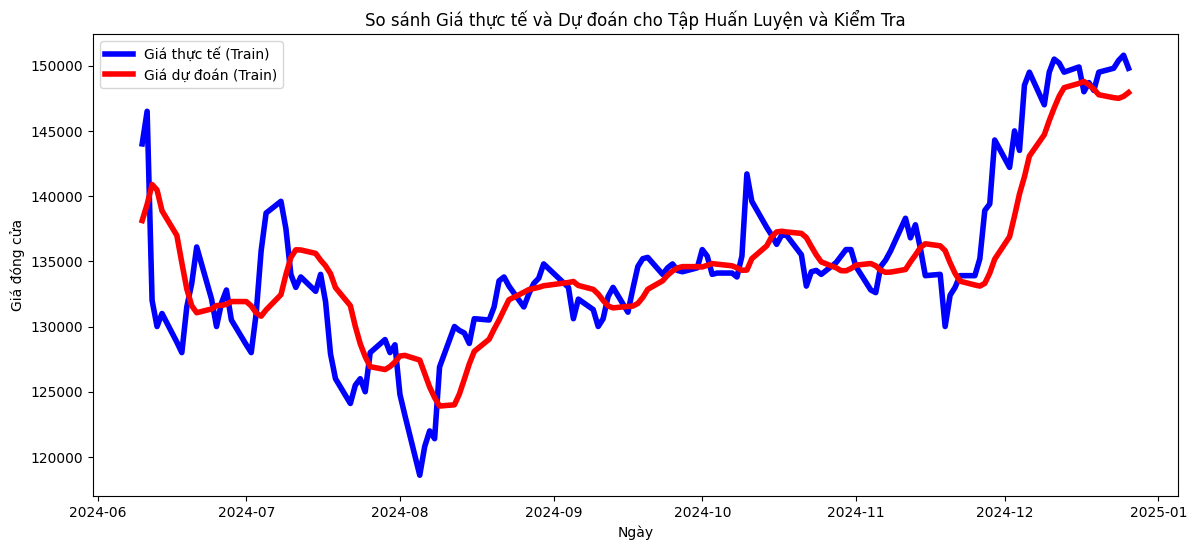

In [32]:
# Tạo lại trục x cho tập huấn luyện (train) sao cho có số lượng phần tử phù hợp
train_dates = data[:training_data_len].index  # Lấy cột Date từ dữ liệu huấn luyện
test_dates = data[training_data_len:].index   # Lấy cột Date từ dữ liệu kiểm tra

# Vẽ biểu đồ cho tập huấn luyện (train) và kiểm tra (test)
plt.figure(figsize=(14, 6))

# Vẽ giá thực tế cho tập huấn luyện (train)
plt.plot(train_dates[50:], y_train, color='blue', label='Giá thực tế (Train)', linewidth=4)  # Giá thực tế (train)
plt.plot(train_dates[50:], y_train_predict, color='red', label='Giá dự đoán (Train)', linewidth=4)  # Giá dự đoán (train)

# Thiết lập tiêu đề, trục và hiển thị thêm trục y là giá trị đóng cửa
plt.title('So sánh Giá thực tế và Dự đoán cho Tập Huấn Luyện và Kiểm Tra')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()

# Hiển thị biểu đồ
plt.show()

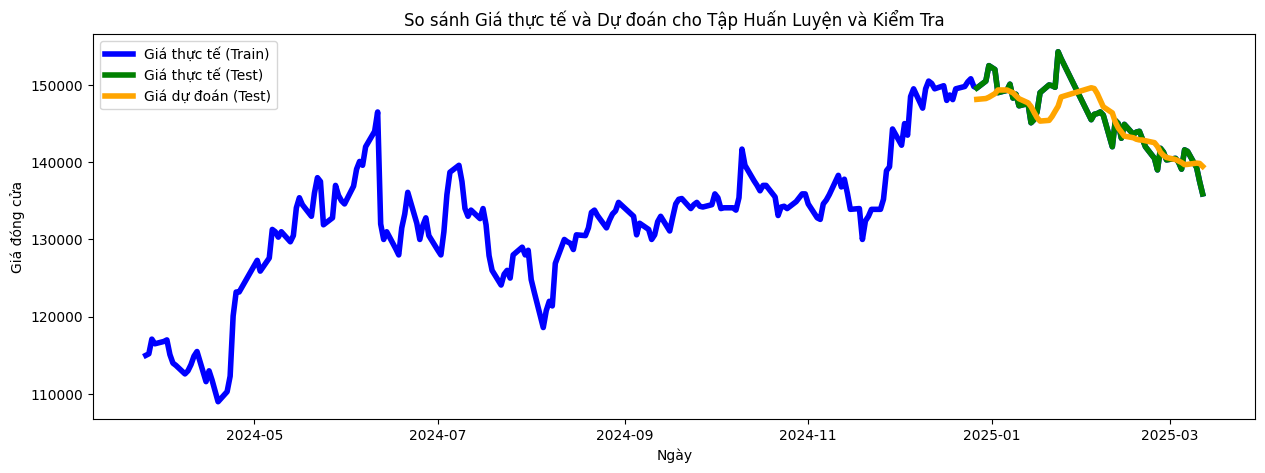

In [33]:
# Tạo lại trục x cho tập huấn luyện (train) sao cho có số lượng phần tử phù hợp
train_dates = data[:training_data_len].index  # Lấy cột Date từ dữ liệu huấn luyện
test_dates = data[training_data_len:].index   # Lấy cột Date từ dữ liệu kiểm tra

plt.figure(figsize=(15,5))
# Vẽ giá thực tế cho tập kiểm tra (test)
plt.plot(data.index, data['Closing Price'], color='blue', label='Giá thực tế (Train)', linewidth=4)  # Giá thực tế (test)
plt.plot(test_dates, y_test, color='green', label='Giá thực tế (Test)', linewidth=4)  # Giá thực tế (test)
plt.plot(test_dates, y_test_predict, color='orange', label='Giá dự đoán (Test)', linewidth=4)  # Giá dự đoán (test)

# Thiết lập tiêu đề, trục và hiển thị thêm trục y là giá trị đóng cửa
plt.title('So sánh Giá thực tế và Dự đoán cho Tập Huấn Luyện và Kiểm Tra')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()

# Hiển thị biểu đồ
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
            Predicted Closing Price
2025-03-13            137673.093750
2025-03-14            137103.437500
2025-03-15            136612.046875
2025-03-16            136175.703125
2025-03-17            135780.109375


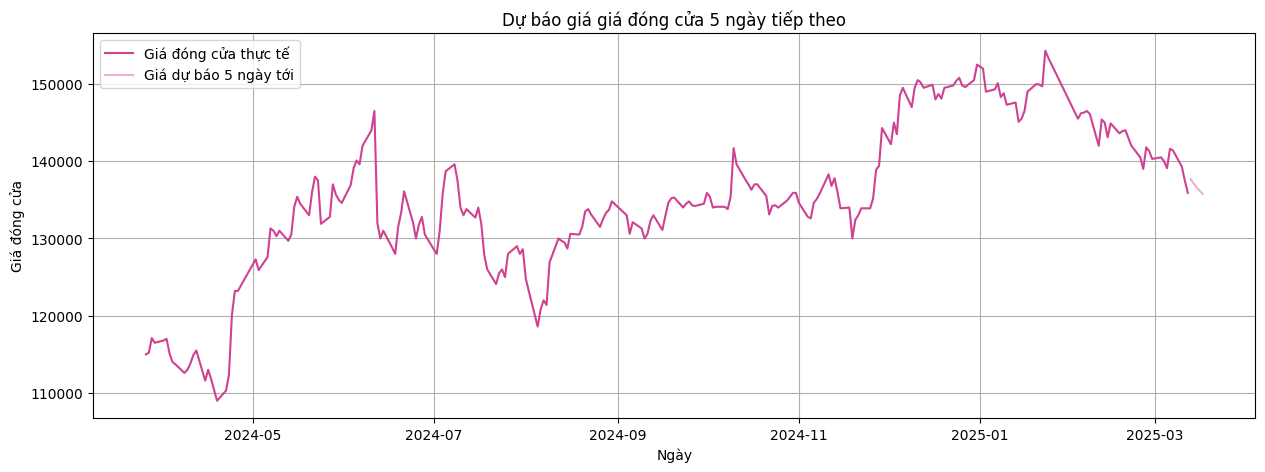

In [34]:
# Bước 1: Lấy 50 ngày gần nhất (Closing Price) để predict
last_50_days = data[-50:].values  # data là tập Closing Price ban đầu của bạn
last_50_days_scaled = scaler.transform(last_50_days)  # scale theo scaler cũ

# Bước 2: Chuẩn bị input cho model
X_predict = last_50_days_scaled.reshape(1, 50, 1)

# Bước 3: Dự báo liên tiếp 5 ngày
future_predictions = []

for _ in range(5):  # Dự báo 5 ngày
    pred_price = model.predict(X_predict)
    future_predictions.append(pred_price[0, 0])

    # Cập nhật X_predict: bỏ giá cũ, thêm giá mới vào cuối
    X_predict = np.append(X_predict[:, 1:, :], pred_price.reshape(1, 1, 1), axis=1)

# Bước 4: Inverse scale về giá thực tế
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_real = scaler.inverse_transform(future_predictions)

# Bước 5: Tạo DataFrame kết quả
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

future_df = pd.DataFrame(future_predictions_real, index=future_dates, columns=['Predicted Closing Price'])

print(future_df)

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(15,5))
plt.plot(data.index, data['Closing Price'], label='Giá đóng cửa thực tế')
plt.plot(future_df.index, future_df['Predicted Closing Price'], label='Giá dự báo 5 ngày tới')
plt.title('Dự báo giá giá đóng cửa 5 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Lấy index ngày từ DataFrame gốc
date_index = data.index

# Xác định ngày tương ứng cho tập test
test_index = date_index[training_data_len:]

# Khớp độ dài với y_test_predict
test_index = test_index[-len(y_test_predict):]

# Tạo DataFrame kết quả
compare_df = pd.DataFrame({
    'Actual Closing Price': y_test.values.flatten(),
    'Predicted Closing Price': y_test_predict.flatten()
}, index=test_index)

# Xem vài dòng đầu tiên
compare_df

,Actual Closing Price,Predicted Closing Price
Date,,
2024-12-27,149600,148134.984375
2024-12-30,150500,148239.625000
2024-12-31,152500,148409.328125
2025-01-02,152000,148870.296875
2025-01-03,149000,149346.421875
2025-01-06,149300,149347.171875
2025-01-07,150100,149156.125000
2025-01-08,148300,148989.828125
2025-01-09,148800,148595.250000


# Tái huấn luyện mô hình

In [ ]:
import yfinance as yf
import datetime as dt

update_date = dt.datetime.now().strftime('%Y-%m-%d')
FPT_quote = yf.download('FPT.VN', start='2025-03-13', end=update_date)

# Tạo khung dữ liệu mới
FPT_quote.columns = FPT_quote.columns.get_level_values(0)
FPT_quote.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-03-13,136500.0,138000.0,136100.0,136100.0,3710200
2025-03-14,131400.0,136300.0,130800.0,135600.0,16251000
2025-03-17,130000.0,132100.0,129600.0,131600.0,7623000
2025-03-18,130000.0,132200.0,130000.0,130100.0,5628500
2025-03-19,124600.0,130600.0,123500.0,130100.0,19264400


In [ ]:
# Lấy đúng cột Closing Price (giá đóng cửa) để khớp với mô hình ban đầu
new_data = FPT_quote[['Close']].copy()
new_data.columns = ['Closing Price']

# Nếu cần chuyển chỉ mục Date về dạng datetime (cho chắc)
new_data.index = pd.to_datetime(new_data.index)

In [38]:
full_data = pd.concat([data, new_data])

full_data = full_data.sort_index()

Kiểm tra lại độ chính xác của mô hình

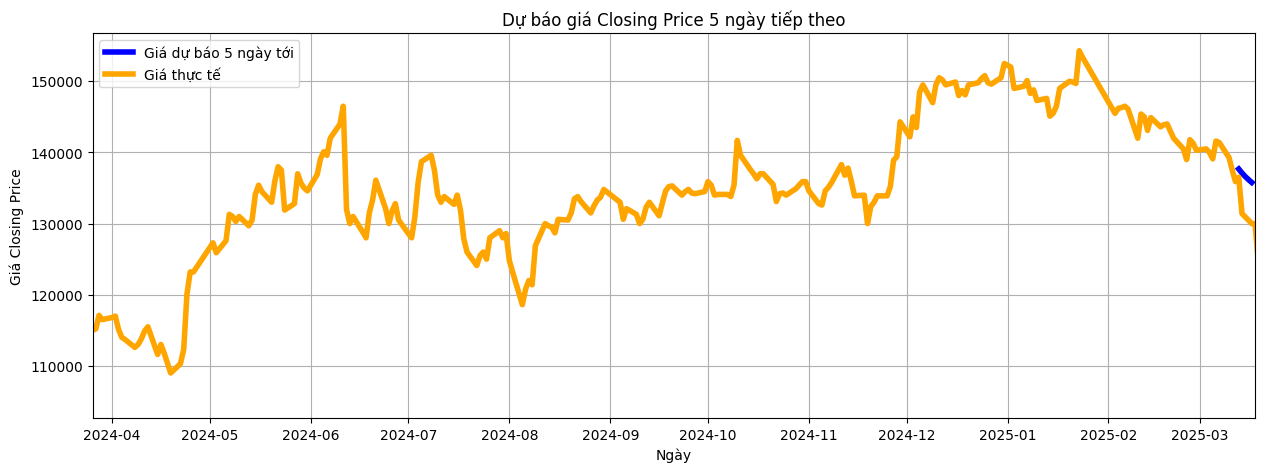

In [45]:
import pandas as pd

# Chuyển end_date thành kiểu datetime
end_date = pd.to_datetime('2025-03-18')

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(15,5))
plt.plot(future_df.index, future_df['Predicted Closing Price'], label='Giá dự báo 5 ngày tới', linewidth=4, color='blue')
plt.plot(full_data.index, full_data['Closing Price'], label='Giá thực tế', linewidth=4, color='orange')
plt.title('Dự báo giá Closing Price 5 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá Closing Price')

# Giới hạn phạm vi trục X từ ngày bắt đầu đến ngày bạn chỉ định (end_date)
plt.xlim(full_data.index[0], end_date)  # Giới hạn ngày từ start của future_df đến end_date

plt.legend()
plt.grid()
plt.show()

# Retrain lại mô hình giúp tối ưu hóa mô hình

In [40]:
# Bước 1: Chuẩn bị dữ liệu đầu vào
data_values = full_data['Closing Price'].values.reshape(-1, 1)

# Bước 2: Scale dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_values)

# Bước 3: Tạo tập train (lookback = 50 ngày)
def create_dataset(dataset, lookback=50):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaled_data)

# Bước 4: Reshape đầu vào cho LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Bước 5: Khởi tạo và huấn luyện lại mô hình
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

Epoch 1/30


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2557
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0181
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0134
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0085
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0072
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0058
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0056
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0052
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059
Epoch 16/30
15/

------------------------------

# DỰ BÁO 3 NGÀY TIẾP THEO SAU TOÀN BỘ DỮ LIỆU

In [41]:
# Bước 1: Lấy 50 ngày cuối cùng làm input
last_50 = scaled_data[-50:]
X_input = last_50.reshape((1, 50, 1))

# Bước 2: Dự báo liên tiếp 3 ngày
predictions = []

for _ in range(3):
    pred = model.predict(X_input, verbose=0)
    predictions.append(pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Bước 3: Inverse scale
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Bước 4: Tạo ngày tương ứng
last_date = full_data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=3)

# Bước 5: Tạo DataFrame kết quả
next3_df = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted Closing Price'])

next3_df

,Predicted Closing Price
2025-05-08,110683.671875
2025-05-09,110845.500000
2025-05-10,111027.093750


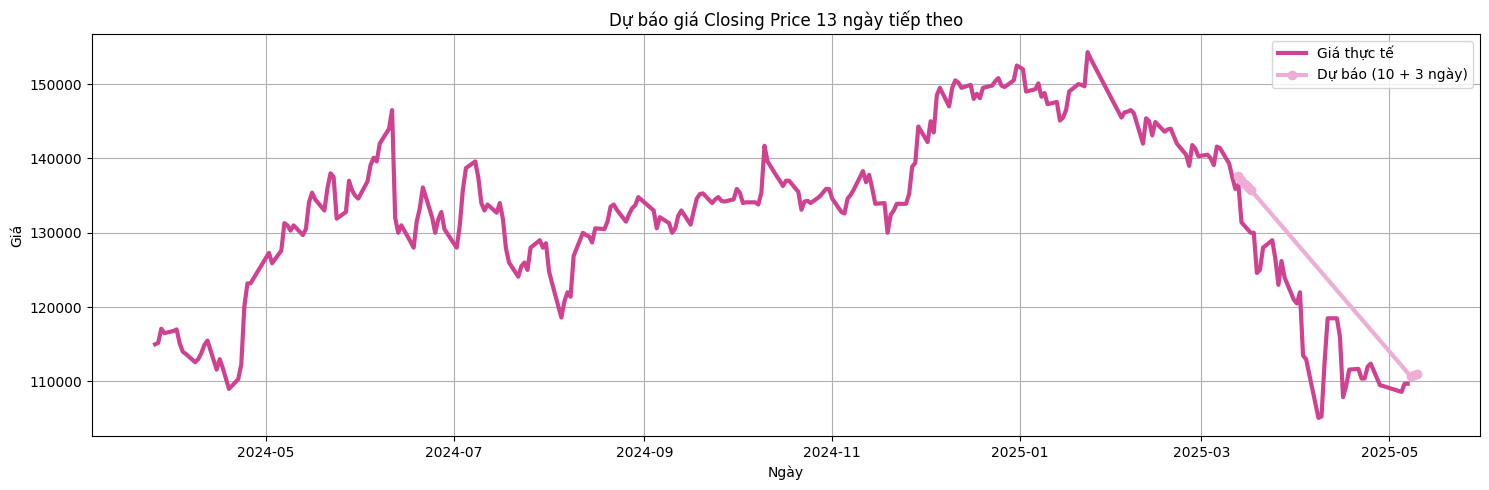

In [ ]:
combined_forecast = pd.concat([future_df, next3_df])

plt.figure(figsize=(15,5))
plt.plot(full_data.index, full_data['Closing Price'], label='Giá thực tế', linewidth=3)
plt.plot(combined_forecast.index, combined_forecast['Predicted Closing Price'],
         label='Dự báo (5 + 3 ngày)', linewidth = 3, marker='o')
plt.title('Dự báo giá Closing Price 3 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
real_data = full_data[['Closing Price']].copy()

# Ghép dữ liệu thực và dữ liệu dự báo vào bảng
full_combined_data = pd.concat([real_data, combined_forecast], axis=1)

full_combined_data

,Closing Price,Predicted Closing Price
2024-03-26,115000.0,NaN
2024-03-27,115200.0,NaN
2024-03-28,117100.0,NaN
2024-03-29,116500.0,NaN
2024-04-01,116800.0,NaN
...,...,...
2025-05-06,109700.0,NaN
2025-05-07,109700.0,NaN
2025-05-08,NaN,110683.671875
2025-05-09,NaN,110845.500000


In [44]:
full_combined_data.to_csv('Du_bao_FPT.csv', index=True)